In [1]:
#import sys
#!{sys.executable} -m pip install corner
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib notebook
import scipy
from scipy import optimize
import scipy.stats as stats
import emcee
import corner

<ErrorbarContainer object of 3 artists>

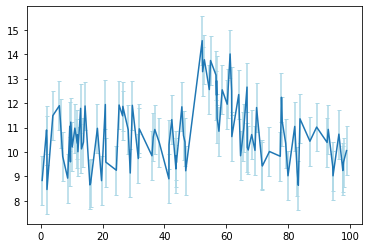

In [2]:
data = np.load("../solutions/transient.npy", "r")
#print(file[:, 0])
#plt.plot(file[:, 0], file[:, 1])
x = data[:, 0]
y = data[:, 1]
sigma_y = data[:,2]
plt.errorbar(x, y, yerr = sigma_y , xerr=None, ecolor='lightblue', capsize = 2, capthick = 1)

One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.


def model_ (t, t0, b, A, alpha):
    if (t < t0):
        return b
    else:
        return b + A * np.exp(- alpha * (t-t0))

# par = [t0,  b,  A , alpha]


In [3]:
def model_ (t, par):
    modello = []
    for time in t:
        if (time < par[0]):
            modello.append(par[1])              
        else:
            modello.append(par[1] + par[2] * np.exp(- par[3] * (time-par[0])))
    
    return modello

In [4]:
# compute the data log-likelihood given a model
def logL(par, data, model=model_):

    """Gaussian log-likelihood of the model """
    x = data [:,0]
    y = data [:,1]
    sigma_y = data [:,2]

    y_fit = model(x, par)
    return sum(stats.norm.logpdf(*args) for args in zip(y, y_fit, sigma_y))

# a direct optimization approach is used to get best model 
# parameters (which minimize -logL)
def best_par(model=model_, data=data):
    par_0 = [48, 10, 4, 1/20]
    
    neg_logL = lambda par : -logL(par, data, model)
    return scipy.optimize.fmin_bfgs(neg_logL, par_0, disp=False)

we have to write down a likelihood:

gaussian likelihood ---> since central limit theorem etc.

product of probabilities: proportional of the exp

L(


[47.8717214  10.28787809  6.34818037  0.11890551]


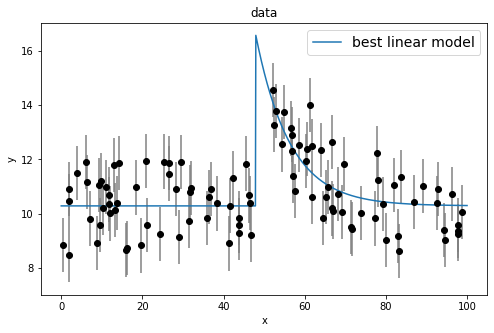

In [5]:
Ndata = x.size

# get best-fit parameters for linear, quadratic and cubic models
par = best_par(model_, data=data)
print(par)

# generate best fit lines on a fine grid 
xgrid = np.linspace(0, 100, 1000)
yfit = model_(xgrid, par)


# plot 
fig, ax = plt.subplots(figsize=(8, 5))
ax.errorbar(x, y, sigma_y, fmt='ok', ecolor='gray')
ax.plot(xgrid, yfit, label='best linear model')
ax.legend(loc='best', fontsize=14)
ax.set(xlabel='x', ylabel='y', title='data');


3) Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$ (careful: uniform in $\ln\alpha$, not $\alpha$).

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 



In [6]:
np.random.seed(21)
Ndata = x.size

## first define the prior, uniform pdf (scherzone questo solo il plot, realtà è più facile)

[[], [], [], []]


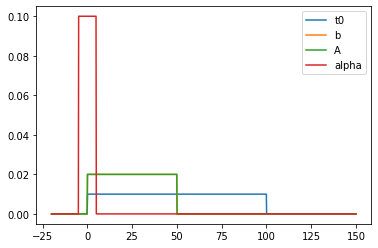

In [10]:
# par = [t0, b, A , alpha]
x_linspace = np.linspace(-20,150, 1000)
par0_mcmc = [[],[],[],[]]
print(par0_mcmc)
def Prior_plot(x):
    for xi in x:
        
        par0_mcmc[0].append(stats.uniform.pdf(xi, loc=0, scale=100))
        par0_mcmc[1].append(stats.uniform.pdf(xi, loc=0, scale=50))
        par0_mcmc[2].append(stats.uniform.pdf(xi, loc=0, scale=50))
        ln_alpha = stats.uniform.pdf(xi, loc=-5, scale=10)
        par0_mcmc[3].append((np.exp(ln_alpha)))
    return par0_mcmc

par0_mcmc = Prior_plot(x_linspace)
    
#plot
plt.plot(x_linspace, par0_mcmc[0], label = 't0' )
plt.plot(x_linspace, par0_mcmc[1], label = 'b' )
plt.plot(x_linspace, par0_mcmc[2], label = 'A' )
plt.plot(x_linspace, np.log(par0_mcmc[3]), label = 'alpha')
plt.legend()
plt.show()

    

# vera definizione della prior

In [34]:
def Prior(par_mcmc):
    prior_0 = stats.uniform(0,100).pdf(par_mcmc[0])
    prior_1 = stats.uniform(0,50).pdf(par_mcmc[1])
    prior_2 = stats.uniform(0,50).pdf(par_mcmc[2])
    prior_3 = stats.uniform(-5,5).pdf(np.log(par_mcmc[3]))
    
                                      
    return prior_0 * prior_1 * prior_2* prior_3


def logPrior(par_mcmc):
    b, A, t0, alpha = par_mcmc
    if 0 < b < 50 and 0 < A < 50 and 0 < t0 < 100 and -5 < np.log(alpha) < 5:
        return 0.0  # log(1) = 0 for valid parameters
    else:
        return -np.inf  # log(0) = -inf for invalid parameters


## we have already defined the likelihood in the previous point of the exercise,
# LET'S GET THE POSTERIOR
(actually the log)

In [37]:
def logPosterior (par_mcmc, data, model = model_):
    logPrior = np.log(Prior(par_mcmc))
    if not np.isfinite(logPrior):
        return -np.inf
    return logL(par_mcmc, data, model) + logPrior

In [40]:
ndim = 4  # number of parameters in the model
nwalkers = 10  # number of MCMC walkers, It is unadvisable to use a red-blue move with fewer walkers than twice the number of dimensions.
nsteps = 5000  # number of MCMC steps to take **for each walker**
print( "data dimensions: ", np.shape(data))

# initialize the parameters 
np.random.seed(0)
starting_guesses = np.array(par)+ 1e-4* np.random.random((nwalkers, ndim))

# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior, args=(data, ))
#sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)

sampler.run_mcmc(starting_guesses, nsteps, progress = True)
print("done")

data dimensions:  (100, 3)


  3%|▎         | 131/5000 [00:25<12:44,  6.37it/s]/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
  8%|▊         | 375/5000 [01:13<15:17,  5.04it/s]/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
100%|██████████| 5000/5000 [15:52<00:00,  5.25it/s]

done


(10, 5000, 4)


<IPython.core.display.Javascript object>


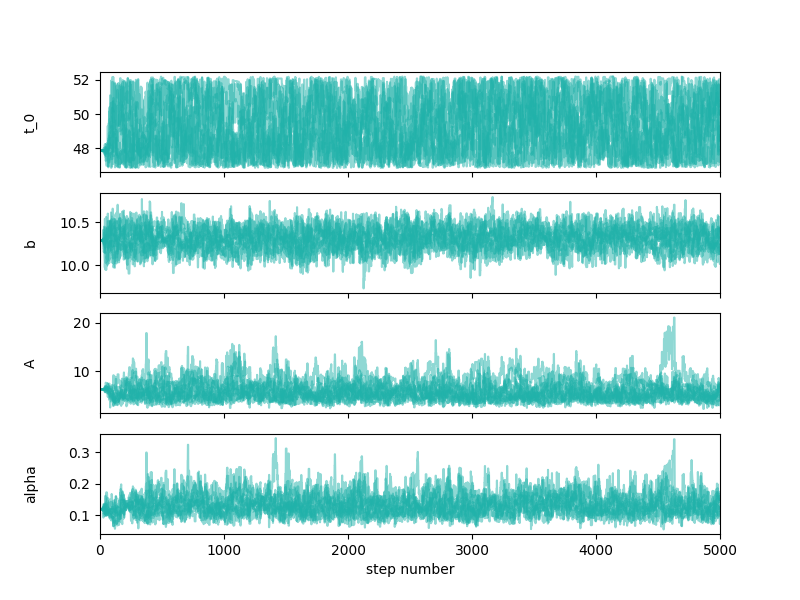

/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  


In [41]:
print(sampler.chain.shape) #original chain structure
# sampler.chain is of shape (nwalkers, nsteps, ndim)
fig, axes = plt.subplots(4, figsize=(8, 6), sharex=True)
samples = sampler.get_chain()
labels = ["t_0", "b","A","log_alpha"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.5, color = "lightseagreen")
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

solutions_emcee = open("sol_emcee.txt", "a")

solutions_emcee.write("50000: " + str(sampler) + str(sampler.chain) + "\n")

solutions_emcee.close()

## should add a burn-in period  

(SHOULD I FIRST LOOK AT AUTOCORR LENGTH AND THROW AWAY A COUPLE OF TIMES THAT NUMBER ?? )

In [54]:
burn = 200  # "burn-in" period to let chains stabilize
# throw-out the burn-in points and reshape:
emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)
print("burned and flattened chain ",emcee_trace.shape) #burned and flattened chain WHERE IS THINNING ? I NEED TO TAKE THE AUTOCORRELATION LENGHT INOTO ACCOUNT
emcee_trace.flatten()
len(emcee_trace.flatten())

burned and flattened chain  (48000, 4)


192000

## still should take autocorrelation length into account ---> thinning

In [55]:
print(sampler.chain.shape) #original chain structure
print(sampler.acceptance_fraction)
tau = sampler.get_autocorr_time()

(10, 5000, 4)
[0.521  0.525  0.5348 0.5272 0.5326 0.5058 0.5404 0.5448 0.5102 0.5248]


In [56]:
# Now take one point every autocorrelation lenght
tau = sampler.get_autocorr_time()
print(tau, "This suggests that only about", tau[0], " steps are needed for the chain to “forget” where it started. It’s not unreasonable to throw away a few times this number of steps as “burn-in”. Let’s discard the initial 100 steps, thin by about half the autocorrelation time (15 steps), and flatten the chain so that we have a flat list of samples:")

#thin = int(tau+1)
#emcee_thinned = sampler.get_chain(discard=burn, thin=30, flat=True)
emcee_trace = sampler.get_chain(discard=burn, thin=30, flat=True).flatten()

[74.36948651 63.13900299 87.37010228 73.49458119] This suggests that only about 74.36948650605491  steps are needed for the chain to “forget” where it started. It’s not unreasonable to throw away a few times this number of steps as “burn-in”. Let’s discard the initial 100 steps, thin by about half the autocorrelation time (15 steps), and flatten the chain so that we have a flat list of samples:


In [58]:
print(tau)

emcee_thinned = sampler.get_chain(discard=burn, thin=30, flat=True)


[74.36948651 63.13900299 87.37010228 73.49458119]


## Now we want to see the plot over data (?) 

# NO!! medians of marginals---> wrong !! (i should use... ?)
IN MY POSTERIORS I HAVE DIFFERENT MODELS (ONE FOR EACH LINE (?))
TAKING THE MEDIAN OF EACH MARGINALS GIVES ME A COMBINATION OF PARAMETERS THAT I DON'T HAVE IN MY MODELS, these numbers don't live in the 4-parameter space

## to extract a summary statistic:
I SHOULD TAKE SOMETHING LIKE THE MAXIMUM A POSTERIORI

## CORNER PLOT

<IPython.core.display.Javascript object>


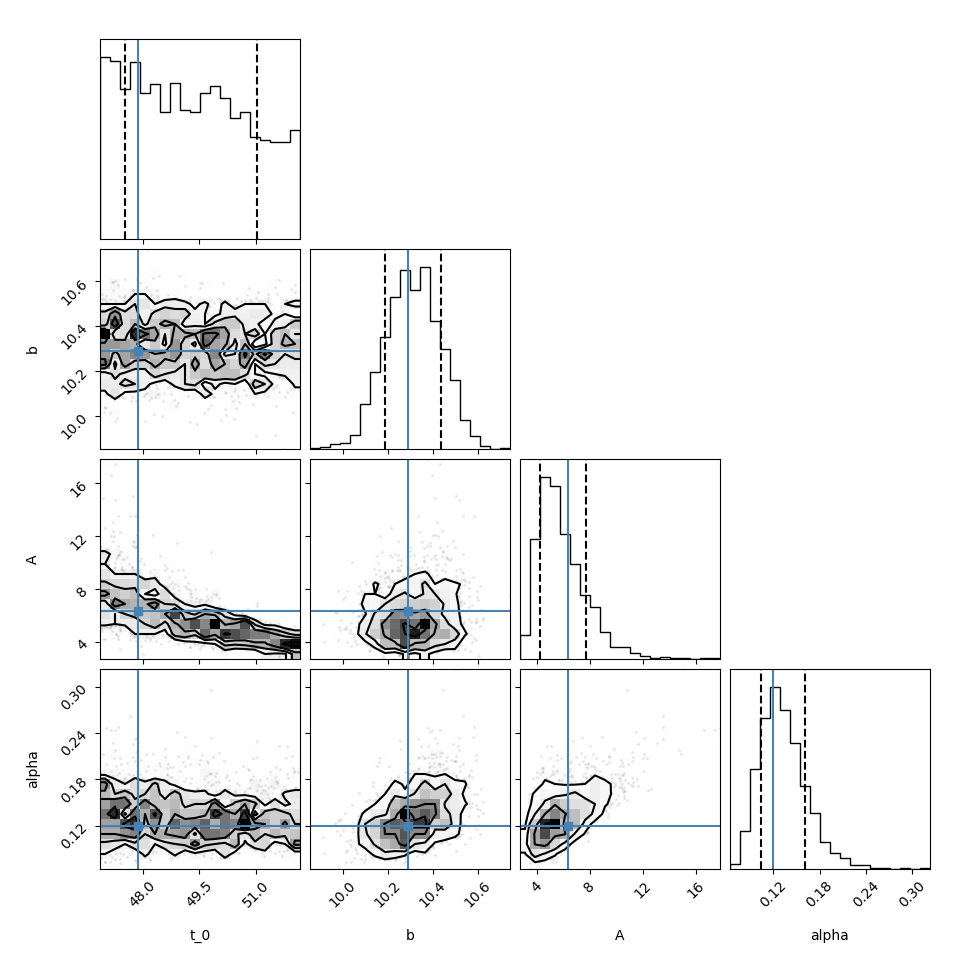

In [60]:
import corner

fig = corner.corner(
#    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
    #I don't have the true values, I can plot the values i got from max likelihood estimation
    emcee_thinned, labels=labels, truths=par, quantiles= (0.16,0.84)
);

# EXERCISE LECTURE 12 ----> LET'S DO THE SAME BUT WITH NESTED SAMPLING

### Time to get your hands dirty.  The transient Universe


Let's go back to our previous example on the astrophysical transient.


8) Fit the same model from before with the same priors,  but this time use nested sampling.

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

9) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data?

In [11]:
import dynesty


I have my likelihood, do i have to normalize it ?
then define the prior as dynesty wants

In [12]:
def model_ (t, par):
    modello = []
    for time in t:
        if (time < par[0]):
            modello.append(par[1])              
        else:
            modello.append(par[1] + par[2] * np.exp(- par[3] * (time-par[0])))
    
    return modello

In [17]:
def prior_transform(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior within [-10., 10.) for each variable."""
    prior_0 = stats.uniform(30,70).ppf(u[0])
    prior_1 = stats.uniform(0,20).ppf(u[1])
    prior_2 = stats.uniform(0,20).ppf(u[2])
    prior_3 = stats.uniform(np.exp(-5),np.exp(2)).ppf(u[3]) ###STIMIAMO ALPHA NON LOG ALPHA
    
    #return (prior_0 *prior_1* prior_2* prior_3)
                                
    return prior_0, prior_1, prior_2, prior_3

def loglike_normalized(par, data = data, model=model_):

    """Gaussian log-likelihood of the model """
    x = data [:,0]
    y = data [:,1]
    sigma_y = data [:,2]

    y_fit = model(x, par)
       
    return sum ( (stats.norm.logpdf(*args) - np.log(np.sqrt(2*np.pi)*args[2]) for args in zip(y, y_fit, sigma_y)) )

In [18]:
# "Static" nested sampling.
ndim = 4  # number of parameters in the model
#logliken = loglike_normalized(par, data = data, model=model_)
#print(logliken)

sampler = dynesty.NestedSampler(loglike_normalized, prior_transform, ndim, nlive = 1000)
sampler.run_nested()
sresults = sampler.results

14134it [37:06,  6.35it/s, +1000 | bound: 77 | nc: 1 | ncall: 151705 | eff(%): 10.042 | loglstar:   -inf < -232.543 <    inf | logz: -246.589 +/-  0.123 | dlogz:  0.001 >  1.009]


In [19]:
sresults = sampler.results

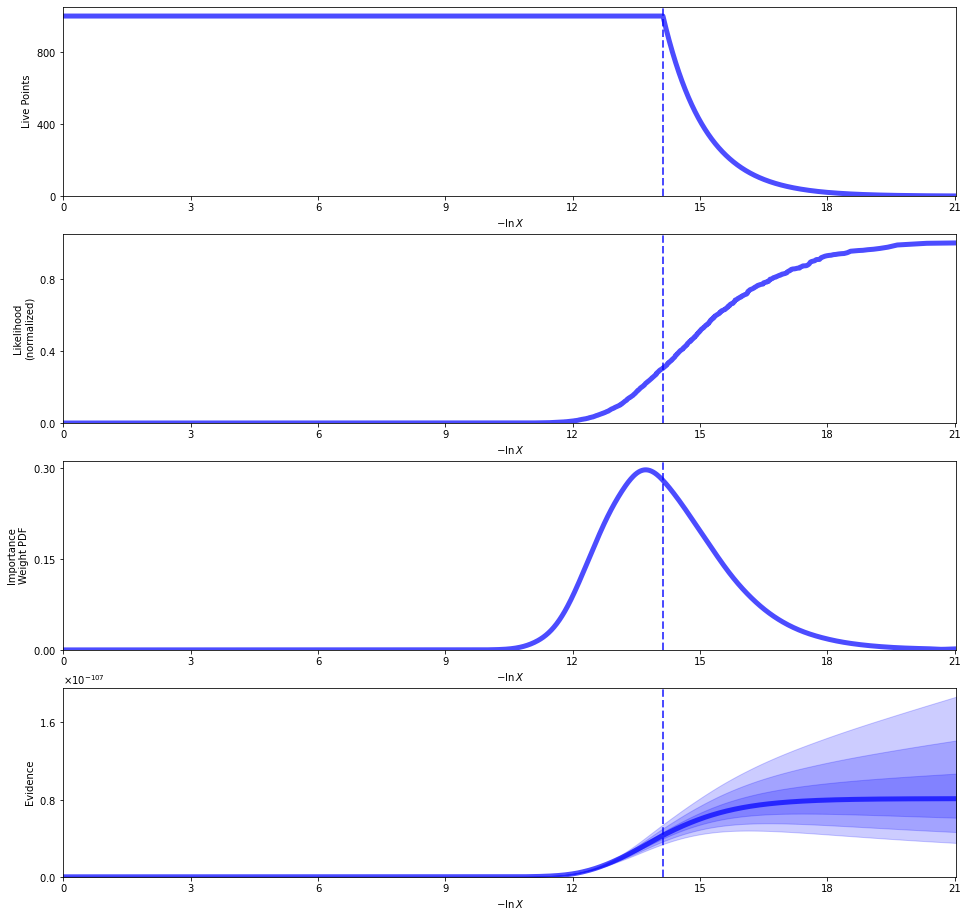

In [20]:
from dynesty import plotting as dyplot
plt.rcParams['figure.figsize'] = (8,8)
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)

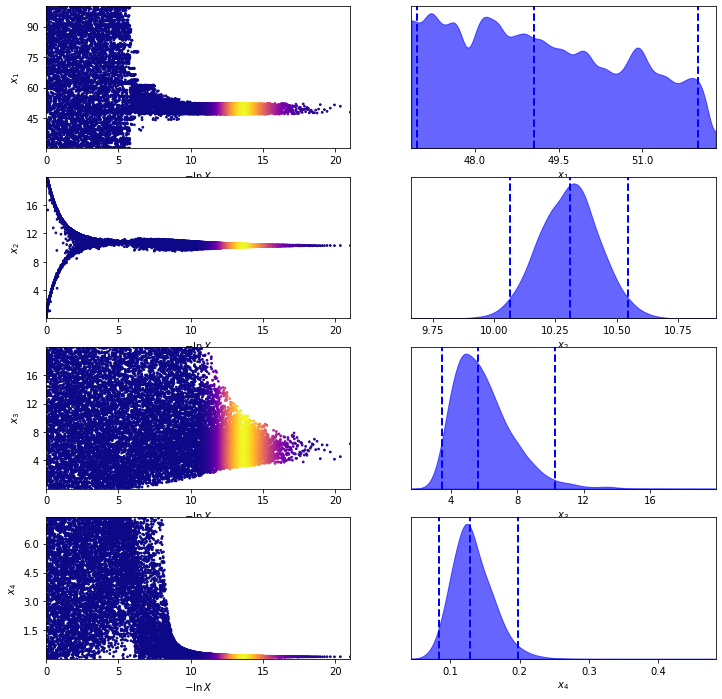

In [21]:
tfig, taxes = dyplot.traceplot(sresults)

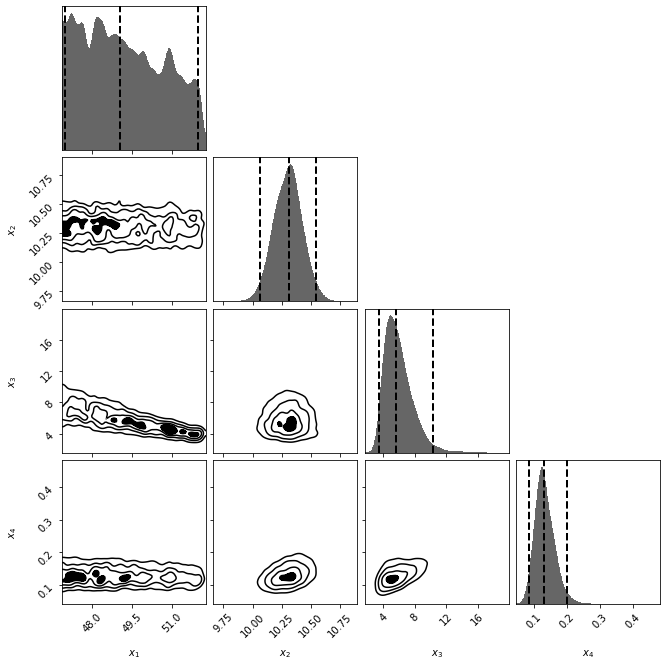

In [22]:
cfig, caxes = dyplot.cornerplot(sresults)

In [ ]:
sresults_vecchio = sampler.results